In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image

%matplotlib inline

# Naive Bayes and Support Vector Machines

Today we'll look at two more very commonly-used, widely applicable classification methods.

* Naive Bayes Classifier
* Support Vector Machine

## Naive Bayes

Let's start from the definition of conditional probability:

$$ P[A\,|\,C] = \frac{P[A \text{ and } C]}{P[C]} $$

So:

$$ P[A \text{ and } C] = P[A\,|\,C] \cdot P[C]. $$

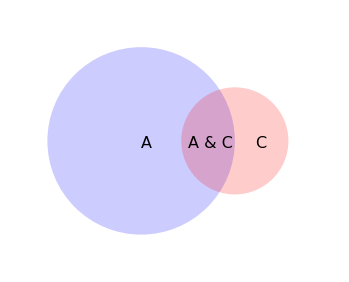

In [2]:
plt.figure(figsize = (6,6))
ax=plt.gcf().gca()
circle = mp.patches.Circle([1, 1], 0.7, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
circle = mp.patches.Circle([1.7, 1], 0.4, facecolor = 'red', alpha = 0.2)
ax.add_artist(circle)
ax.axis('square')
ax.axis('off')
plt.xlim([0, 2.5])
plt.ylim([0, 2])
plt.text(1, .95, 'A', fontsize = 16)
plt.text(1.85, .95, 'C', fontsize = 16)
plt.text(1.35, .95, 'A & C', fontsize = 16);
# plt.title(r'$P[C\,|\,A]\,P[A] = P[A\,|\,C]\,P[C]$'); 

Switching the roles of $A$ and $C$, we can equally say:

$$ P[C \text{ and } A] = P[C\,|\,A] \cdot P[A]. $$

Now $P[C \text{ and } A] = P[A \text{ and } C]$, so:
    
$$ P[A\,|\,C] \cdot P[C] = P[C\,|\,A] \cdot P[A] $$

Rearranging, we get __Bayes' Rule__:
    
$$ P[A\,|\,C] = \frac{P[C\,|\,A] \cdot P[A]}{P[C]}. $$

So there is nothing "magic" about Bayes' Rule: it simply follows from the basic laws of probability.

However, it is __very__ useful!

The reason is that often, $P[A\,|\,C]$ is __not__ known, but the expressions on the right __are__ known.

(We've already seen how this is used in the EM algorithm for Gaussian Mixture Modeling.)

### Using Bayes Rule in a Classifier

Let's start with a simple example:
   * A doctor knows that meningitis causes a stiff neck 75% of the time.
   * This is $P[S\,|\,M]$. 
   
A patient presents with a stiff neck.  What is the probability she has meningitis?

Well, we can't say.  What we know is $P[S\,|\,M]$, but what we want to know is $P[M\,|\,S]$!

Now perhaps the doctor knows that 
   * 1 in 20 people in the population have a stiff neck at any given time
       * $P[S] = 1/20$
   * 1 in 10,000 people in the population have meningitis at any given time
       * $P[M] = 1/10000$

   
Now, we can calculate the answer needed:

$$ P[M\,|\,S] = \frac{P[S\,|\,M]}{P[S]}\cdot P[M] = \frac{3/4}{1/20} \cdot 1/10000 = \fbox{$15 \cdot 1/10000$} = 0.0015. $$

I wrote the expressions above that way to point out the essence of Bayesian reasoning:
* A random person has probability 1/10000 of having meningitis
* When __we learn__ that the person has a stiff neck, it __increases their probability__ by a factor of 15.



We are going to use this same principle to construct a classifier.

Given a set of items with features and class labels,

the __class label__ will play the role of "meningitis" and the various __attributes__ of the item will play the role of "stiff neck."

We will then ask "how does the value of each feature change the probability of the class label?"

More formally:
    
Consider an item $\mathbf{x}$ having attributes $x_1, x_2, \dots, x_n$.

There are various classes (labels) for items: $C_1, \dots, C_k$.

Our goal is to predict the class of $\mathbf{x}$.

To do that, we will compute $P[C_1\,|\,\mathbf{x}], P[C_2\,|\,\mathbf{x}], \dots, P[C_k\,|\,\mathbf{x}]$.

These form a __soft classification__ of $\mathbf{x}$.

From them, we can form a hard classification.  One way would simply be to choose the class with highest probability.

This is the MAP (Maximum A Posteriori) Estimate: 

$$\hat{C} = \arg\max_{\{C_i\}} P[C_i\,|\,\mathbf{x}].$$

Now $P[C_i\,|\,\mathbf{x}] = P[C_i\,|\,x_1, x_2, \dots, x_n]$

How can we approach this problem?

The __key idea__ is that Bayes Rule makes clear that 

$$ P[C_i\,|\,\mathbf{x}] = \frac{P[\mathbf{x}\,|\,C_i]}{P[\mathbf{x}]} \cdot P[C_i] $$

Now, when we vary $C_i$ in the above expression, $P[\mathbf{x}]$ is not changing.

So ... 

The $\hat{C}$ that maximizes $P[C_i\,|\,x_1, x_2, \dots, x_n]$ is the __same__ as the $\hat{C}$ that maximizes $P[x_1, x_2, \dots, x_n\,|\,C_i]\cdot P[C_i]$.

This gives us an angle of attack on the problem.

The difficult problem that remains is how to estimate

$$ P[x_1, x_2, \dots, x_n\,|\,C_i]. $$

To see the challenge, imagine if we tried to compute this directly from data. 

Attacking head-on, we could use a histogram to estimate the necessary distribution.  In other words, simply count up how many times we see each combination of feature values.

Let's say there are 10 possible values for each feature, and there are 20 features. 

Then for each class $C_i$ we need to construct a histogram with $10^{20}$ bins!   

We would never expect to have enough data to fill all those bins.

The underlying problem we face is the high dimensionality of the feature space.

The size of our histogram is __exponential__ in the number of features.

So, we need to find a way to reduce the exponential size of the estimation problem.

We will do that by __factoring__ the distribution $P[x_1, x_2, \dots, x_n\,|\,C_i]$.

Here is where the "Naive" part comes in.

We will __assume__ that __attributes are independent__ in their assignment to items.

That is, for two sets of attributes, the values of the attributes in one set do not affect the values in the other set.    So all correlations among attributes are zero.

This is indeed a "naive" assumption ... but it can be surprisingly effective in practice.

That implies that:
    
$$ P[x_1, x_2, \dots, x_n\,|\,C_i] = P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i]  $$

This is very helpful computationally, because the factors $P[x_j\,|\,C_i]$ are individually much lower-dimensional than the full distribution.

In a naive Bayes model, the quantity we calculate for each class $C_i$ is

$$ P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i] \cdot P[C_i] $$

You can see each conditional probability as a "correction factor" to $P[C_i]$.

Each factor $P[x_j\,|\,C_i]$ tells us how we should update our confidence in $C_i$ based on the value of a particular feature $x_j$.

So, what remains then is to estimate $P[x_j\,|\,C_i]$ for all $x_j$ and $C_i$.

We will estimate these quantities from our training data.

To summarize the steps of Naive Bayes:

__Training__

* Compute all the per-class attribute probabilities $P[x_j\,|\,C_i]$ from training data.
* Compute all the class probabilities $P[C_i]$ from the training data.

__Predicting__

* For a given item $\mathbf{x} = (x_1, x_2, \dots, x_n)$, 
    * For each class $C_i,$ compute $P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i] \cdot P[C_i]$
    * For a hard classification, return the class that maximizes the above expression.

### Computing Attribute Probabilities from Data

All that remains is to compute the conditional attribute probabilities from data.

The strategy depends on the attribute type: discrete or continuous.

<center>
    
<img src="figs/L16-sample-data.png" alt="Figure" width="40%">
    
</center>

__Discrete Attributes__.

Discrete attributes, such as categorical or ordinal attributes, can be handled via histograms.

In the above table, to handle the "Marital Status" attribute for the $\text{Evade} = \text{No}$ class, we need to compute

$$ P[\text{Single}\,|\,\text{Evade }=\text{ No}] = 2 / 7 = 0.29 $$

and

$$ P[\text{Married}\,|\,\text{Evade }=\text{ No}] = 4 / 7 = 0.57 $$

and

$$ P[\text{Divorced}\,|\,\text{Evade }=\text{ No}] = 1 / 7 = 0.14 $$

One problem that can arise is when a histogram bin has zero entries.  Then the conditional probability for this attribute value is zero, which overrides all the other factors and yields a zero probability.

There are various strategies for making small corrections to the counts that avoid this problem.

__Continuous Attributes.__

Continuous attributes can be handled via histograms as well, by binning up the values.   

In the above example, we could create bins to hold ranges of values for "Taxable Income"

However, another commonly used approach is to assume that the data follow a parametric probability distribution.

Most often the Gaussian is used (of course).

So we might form conditional probabilities for "Taxable Income" as

$$ P[\text{Taxable Income} = x\,|\,\text{Evade }=\text{ No}] = \mathcal{N}(x; \mu_\text{No}, \sigma_\text{No}) $$

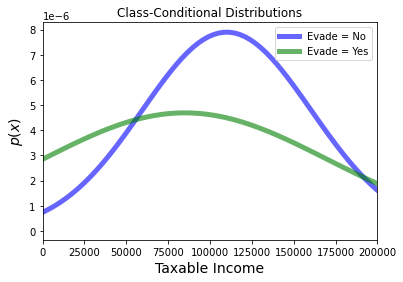

In [3]:
from scipy.stats import norm
eno = np.array([125000, 100000, 70000, 120000, 60000, 220000, 75000])
eyes = np.array([95000, 85000, 75000])
mu_no = np.mean(eno)
sig_no = np.std(eno)
mu_yes = np.mean(eyes)
sig_yes = np.mean(eyes)
plt.figure()
x = np.linspace(norm.ppf(0.001, loc = mu_no, scale = sig_no), norm.ppf(0.999, loc = mu_no, scale = sig_no), 100)
plt.plot(x, norm.pdf(x, loc = mu_no, scale = sig_no),'b-', lw = 5, alpha = 0.6, label = 'Evade = No')
x = np.linspace(norm.ppf(0.001, loc = mu_yes, scale = sig_yes), norm.ppf(0.999, loc = mu_yes, scale = sig_yes), 100)
plt.plot(x, norm.pdf(x, loc = mu_yes, scale = sig_yes),'g-', lw = 5, alpha = 0.6, label = 'Evade = Yes')
plt.xlim([0, 200000])
plt.xlabel('Taxable Income', size=14)
plt.legend(loc = 'best')
plt.title('Class-Conditional Distributions')
plt.ylabel(r'$p(x)$', size=14);

## Support Vector Machines

We now turn to the support vector machine (SVM).  

The SVM is based on explicit geometric considerations about how best to build a classifier.

We start with a set of training data, considered as points in $\mathbb{R}^d$:

<center>
    
<img src="figs/L16-SVM-1.png" alt="Figure" width="40%">
    
</center>

We will start with the idea of a __linear separator__.

This is a hyperplane that forms a decision boundary.

Here is one possible separator:

<center>
    
<img src="figs/L16-SVM-2.png" alt="Figure" width="40%">
    
</center>

Here is another possible separator:

<center>
    
<img src="figs/L16-SVM-3.png" alt="Figure" width="40%">
    
</center>

Which separator is __better__?

Well, they both perfectly separate the two classes in the training data.

<center>
    
<img src="figs/L16-SVM-4.png" alt="Figure" width="40%">
    
</center>

But what we really care about is accuracy on the test data -- __generalization__ ability.

It seems that $B_1$ is a better choice, because it is __farther__ from __both__ classes.

So, new data falling in the region between training classes is more likely to be correctly classified by $B_1$.

<center>
    
<img src="figs/L16-SVM-5.png" alt="Figure" width="40%">
    
</center>

This leads to the principle for choosing the best separator:
    
* We are concerned with the __margin__ between the separator and the data, and
* We prefer the separator that __maximizes the margin__.

In fact, there are theoretical results suggesting that this is an optimal strategy for choosing a separator that has good generalization ability.

### Linear SVM: Separable Case

Let's see how we can train an SVM.

<center>
    
<img src="figs/L16-SVM-5.png" alt="Figure" width="40%">
    
</center>

As usual, our training data consists of tuples $(\mathbf{x}_i, y_i)$, where $\mathbf{x}_i \in \mathbb{R}^d$ and by convention $y_i \in \{-1, 1\}$.

Any decision boundary (such as $B_1$ above) can be written as:

$$ \mathbf{w}^T\mathbf{x} + b = 0. $$

This is simply the equation of a hyperplane, where the $w_i$ and $b$ are the parameters of our model.

<center>
    
<img src="figs/L16-SVM-6.png" alt="Figure" width="40%">
    
</center>

For any $\mathbf{x}_+$ from the positive class (circle) located __above__ the decision boundary, 

$$ \mathbf{w}^T\mathbf{x}_+ + b = k $$

for some __positive__ $k$.

Likewise for any $\mathbf{x}_-$ from the negative class (square) located __below__ the decision boundary, 

$$ \mathbf{w}^T\mathbf{x}_- + b = k' $$

for some __negative__ $k'$.

We'll rescale the parameters $\mathbf{w}$ and $b$ obtaining new equations for the __same__ hyperplanes:

$$ b_{11}: \mathbf{w}^T\mathbf{x}_+ + b = 1 $$
$$ b_{12}: \mathbf{w}^T\mathbf{x}_- + b = -1 $$

How far apart are these hyperplanes?

The vector $\mathbf{w}$ is orthogonal to the hyperplanes $b_{11}$ and $b_{12}$.

So the distance between hyperplanes is the component of $(\mathbf{x}_+ - \mathbf{x}_-)$ in the direction of $\mathbf{w}$.

Which is given by $$d = \frac{\mathbf{w}^T}{\Vert\mathbf{w}\Vert}(\mathbf{x}_+ - \mathbf{x}_-).$$

But subtracting the equations for the hyperplanes, we get:

$$ \mathbf{w}^T(\mathbf{x}_+ - \mathbf{x}_-) = 2 $$

So we conclude:

$$ d = \frac{2}{\Vert\mathbf{w}\Vert}. $$

Now, we have a measure for how good a separator is in terms of its parameters $\mathbf{w}$.

What separators should we consider (ie, search through)?

The answer is, we consider all separators that correctly classify each point.

That is, for all training points ($\mathbf{x}_i, y_i)$:
    
$$ \mathbf{w}^T\mathbf{x}_i + b \ge 1 \text{ if } y_i = 1 $$

and 

$$ \mathbf{w}^T\mathbf{x}_i + b \le -1 \text{ if } y_i = -1 $$

So now we can formally state the problem of defining the __maximum margin separator__:

$$ \mathbf{w}^* = \arg\min_\mathbf{w} \frac{\Vert\mathbf{w}\Vert}{2}$$

Subject to:

$$ \mathbf{w}^T\mathbf{x}_i + b \ge 1 \text{ if } y_i = 1 $$

$$ \mathbf{w}^T\mathbf{x}_i + b \le -1 \text{ if } y_i = -1 $$

This is a __constrained obtimization problem__ with a __quadratic objective function.__

Such problems are called "quadratic programs."   There are standard methods for solving them.   The methods are effective but can be slow.

The complexity of the problem grows with the number of constraints (ie, the number of training points).

Ultimately, only a subset of the training points (constraints) will determine the final solution.

The points that determine the solution "support" it.  They are the __support vectors.__

<center>
    
<img src="figs/L16-SVM-6.png" alt="Figure" width="40%">
    
</center>

### Linear SVM: Non-Separable Case

It may well happen that there is no hyperplane that perfectly separates the classes.

<center>
    
<img src="figs/L16-SVM-7.png" alt="Figure" width="40%">
    
</center>

In this case, we allow points to fall on the "wrong" side of the separator, but we add a penalty for this occurrence.

To express this formally, we introduce __slack__ variables, one per data point: $\xi_i$.   Each $\xi_i$ measures how far the data point is on the "wrong side" of the separator.

The new problem is:

$$ \mathbf{w}^* = \arg\min_\mathbf{w} \left(\frac{\Vert\mathbf{w}\Vert}{2} + C (\sum_{i=1}^N \xi_i)^k\right).$$

Subject to:

$$ \mathbf{w}^T\mathbf{x}_i + b \ge 1-\xi_i \text{ if } y_i = 1 $$

$$ \mathbf{w}^T\mathbf{x}_i + b \le -1+\xi_i \text{ if } y_i = -1 $$

$$ \xi_i \ge 0.$$

Notice we have introduced a hyperparameter: $C$.
    
$C$ essentially controls the complexity of the SVM.  A small value of $C$ will result in allowing many points to fall on the wrong side of the hyperplane (having a nonzero $\xi$) resulting in a large number of support vectors.   So small $C$ results in a more stable decision boundary.

Large $C$ values will penalize violations heavily, and will result in fewer nonzero $\xi$s, leading to fewer support vectors.

### Nonlinear SVM

Finally, we consider the case in which the decision boundary is strongly nonlinear.


<center>
    
<img src="figs/L16-SVM-8.png" alt="Figure" width="40%">
    
</center>

The basic idea here is that we take the data and transform it into another, higher-dimensional space.

Here is the same dataset on transformed coordinates:

$$ x_1 \rightarrow x_1 $$

$$ x_2 \rightarrow (x_1 + x_2)^4 $$

<center>
    
<img src="figs/L16-SVM-9.png" alt="Figure" width="40%">
    
</center>

In high dimension, the points may be (approximately) separable.

To achieve this using the framework of the SVM, we use a __kernel__.

A kernel is a similarity function $K(\mathbf{x}, \mathbf{y})$.

There are many ways to define kernels. 

The most popular kernels are:
    
* Linear: $K(\mathbf{x}, \mathbf{y}) = \mathbf{x}^T\mathbf{y}$
* Polynomial: $K(\mathbf{x}, \mathbf{y}) = (\mathbf{x}^T\mathbf{y})^d$
* Gaussian: $K(\mathbf{x}, \mathbf{y}) = \text{exp}(-\gamma\Vert\mathbf{x}-\mathbf{y}\Vert^2)$

The Gaussian kernel is also called a "Radial Basis Function".   

To use kernels with an SVM, the basic idea is that SVMs are trained using Euclidean distance.

The squared Euclidean distance between two vectors is:
    
$$ \Vert\mathbf{x} - \mathbf{y}\Vert^2 = (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y}) = \mathbf{x}^T\mathbf{x} + \mathbf{y}^T\mathbf{y} - 2\mathbf{x}^T\mathbf{y}$$

So the Euclidean distance can be defined entirely in terms of the __inner product.__

The inner product is in fact a similarity function.  

To train an SVM with a different similarity function, we just replace all the inner products with calls to our kernel function.  

The result is that we can obtain highly curved decision boundaries.

In practice, RBF works well in many cases.

### SVM: Summary

In practice, SVMs have shown good results on many problems.

In particular, it is effective at dealing with high-dimensional data and avoids the curse of dimensionality.

Since all data is represented as vectors, and we are relying on distance functions like Euclidean distance, it is imnportant to pay attention to feature scaling when using SVMs.

# SVM and Naive Bayes in Python

## Support Vector Machines 

Working with the wine dataset available here:

https://archive.ics.uci.edu/ml/datasets/Wine

In [4]:
import sklearn.utils as utils
import sklearn.svm as svm
import sklearn.model_selection as model_selection
import sklearn.datasets as datasets

wine = pd.read_table("data/wine.data", sep=',')

attributes = ['region',
            'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']



wine.columns = attributes
# take 2 attributes and use a two dimensional training dataset
X = wine[['Alcohol', 'Malic acid',]].values
#            'Ash',
#            'Alcalinity of ash',
#            'Magnesium',
#            'Total phenols',
#            'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity',  'Hue', 'OD280/OD315 of diluted wines', 'Proline']].values
grape = wine.pop('region')
y = grape.values
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       177 non-null    float64
 1   Malic acid                    177 non-null    float64
 2   Ash                           177 non-null    float64
 3   Alcalinity of ash             177 non-null    float64
 4   Magnesium                     177 non-null    int64  
 5   Total phenols                 177 non-null    float64
 6   Flavanoids                    177 non-null    float64
 7   Nonflavanoid phenols          177 non-null    float64
 8   Proanthocyanins               177 non-null    float64
 9   Color intensity               177 non-null    float64
 10  Hue                           177 non-null    float64
 11  OD280/OD315 of diluted wines  177 non-null    float64
 12  Proline                       177 non-null    int64  
dtypes: fl

In [5]:
wine.head()
print(X.shape)

X, y = utils.shuffle(X, y, random_state=1)
print(X.shape)
print(y.shape)
print(y)

train_set_size = 100
X_train = X[:train_set_size]  # selects first 100 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 100 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(177, 2)
(177, 2)
(177,)
[2 2 1 2 1 3 2 1 2 2 1 1 2 1 2 2 3 1 2 1 1 2 3 2 1 2 1 1 1 2 3 3 3 1 2 2 2
 3 2 1 1 2 2 1 1 1 2 1 1 2 2 2 3 1 2 2 1 2 3 2 2 1 3 3 2 1 2 1 2 1 3 3 3 3
 2 1 3 1 2 3 1 2 1 3 2 2 1 2 2 3 1 2 2 2 3 2 2 2 3 1 1 1 3 1 2 3 3 1 2 1 2
 2 1 3 2 3 3 3 2 2 2 3 3 2 1 2 1 3 2 2 1 1 2 1 1 1 3 1 3 3 1 2 2 3 1 2 2 1
 1 1 2 2 1 3 3 2 2 2 1 3 3 3 3 3 2 1 1 3 2 3 3 2 3 3 2 3 1]
(100, 2) (100,)
(77, 2) (77,)


In [6]:
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_test))

Accuracy of SVM test set: 0.7142857142857143


Evaluating the fit of the classifier graphically

In [7]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass
    
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

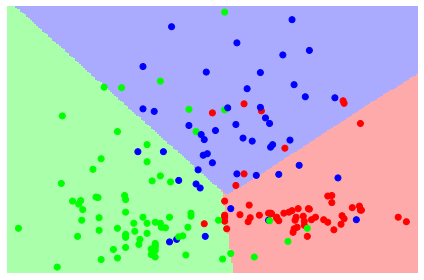

In [8]:
plot_estimator(svc, X, y)

The SVM gets its name from the samples in the dataset from each class that lie closest to the other class. These training samples are called "support vectors" because changing their position in p-dimensional space would change the location of the decision boundary.

In `scikit-learn`, the indices of the support vectors for each class can be found in the `support_vectors_` attribute of the SVC object. 

Here is a 2 class problem using only classes 1 and 2 in the wine dataset.

The support vectors are circled.

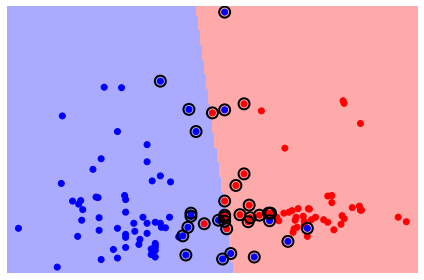

In [9]:
# Extract classes 1 and 2
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]

plot_estimator(svc, X, y);

plt.scatter(svc.support_vectors_[:, 0], 
           svc.support_vectors_[:, 1], 
           s=120, 
           facecolors='none', 
           edgecolors = 'k',
           linewidths=2,
           zorder=10);


## Regularization

These two classes do not appear to be linearly separable.

For non-linearly separable classes we turn to __regularization.__

Regularization is tuned via the C parameter. 

In practice, a large C value means that the number of support vectors is small (less regularization, more model complexity), while a small C implies many support vectors (more regularization, less model complexity). 

`scikit-learn` sets a default value of C=1.

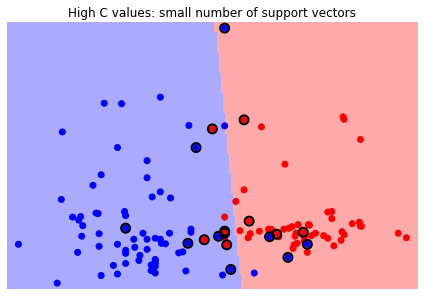

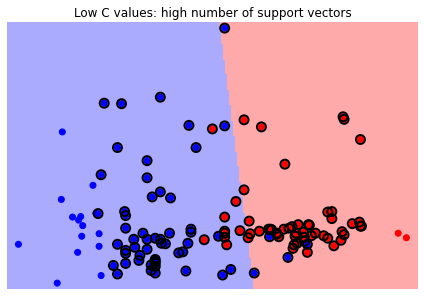

In [10]:
svc = svm.SVC(kernel='linear', C=1e6)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('High C values: small number of support vectors');

svc = svm.SVC(kernel='linear', C=1e-2)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('Low C values: high number of support vectors');

## Kernels

We can also choose from a suite of available kernels:

* linear, 
* poly, 
* rbf, 
* sigmoid, or 
* precomputed.

Or, a custom kernel can be passed as a function. 

Note that the radial basis function (rbf) kernel is just a Gaussian kernel, but with parameter $\gamma = \frac{1}{\sigma^2}$.

__Linear Kernel__

Accuracy of SVM test set: 0.922077922077922


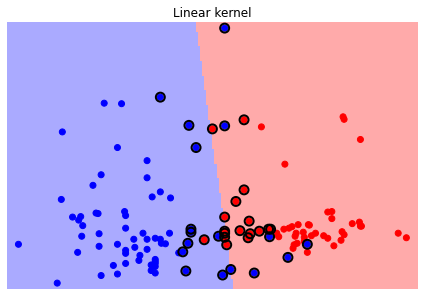

In [11]:
svc_lin = svm.SVC(kernel='linear')
plot_estimator(svc_lin, X, y)
plt.scatter(svc_lin.support_vectors_[:, 0], svc_lin.support_vectors_[:, 1], 
            s=80, facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('Linear kernel')
y_pred_test = svc_lin.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

__Polynomial Kernel__

Accuracy of SVM test set: 0.8961038961038961


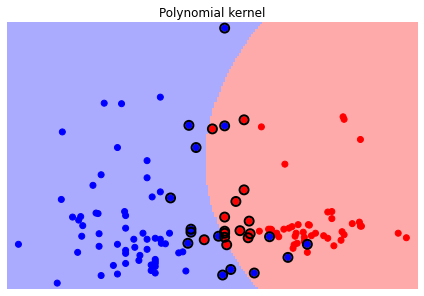

In [12]:
svc_poly = svm.SVC(kernel='poly', degree=4)
plot_estimator(svc_poly, X, y)
plt.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
           s=80, facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('Polynomial kernel')
y_pred_test = svc_poly.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

__RBF kernel__

Accuracy of SVM test set: 0.987012987012987


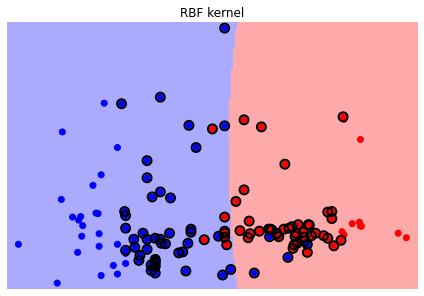

In [13]:
svc_rbf = svm.SVC(kernel='rbf', gamma=1e-2)
plot_estimator(svc_rbf, X, y)
plt.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
           s=80, facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('RBF kernel')
y_pred_test = svc_rbf.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

## Cross-Validation

Let's evaluate our choice of hyperparameter $C$:

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        wine.values, grape.values, test_size=0.4, random_state=0)

In [15]:
f = svm.SVC(kernel='linear', C=1)
f.fit(X_train, y_train)
f.score(X_test, y_test)

0.9577464788732394

So far, this is fine -- but what if we want to vary C?  Now, we are in danger of overfitting if we use the same test data to find the 'best' value of C.

For this we will use the `sklearn` function `cross_val_score` which automatically runs multiple train-test splits:

In [22]:
scores = model_selection.cross_val_score(f, wine.values, grape.values, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()/np.sqrt(5)))

[0.88888889 0.94444444 0.94285714 1.         1.        ]
Accuracy: 0.96 (+/- 0.02)


## The Iris Dataset

As before, we'll look at the Iris dataset again.

In [17]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

/Users/crovella/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


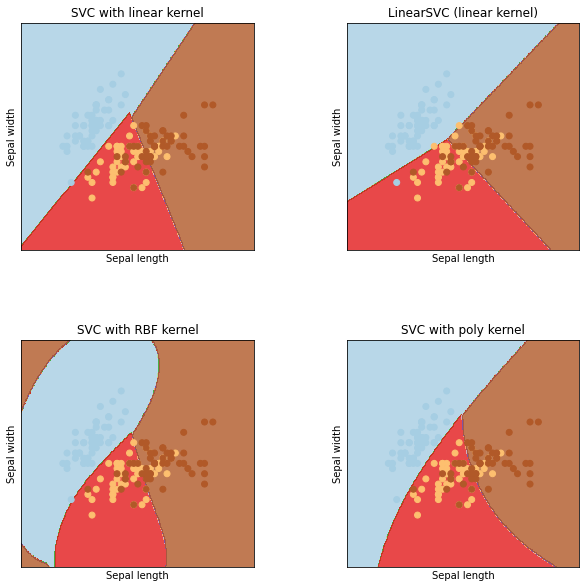

In [18]:
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel', 'SVC with poly kernel']

fig = plt.figure(figsize=(10,10))

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Naive Bayes

To use Naive Bayes "out of the box", one has to treat all the features as either:
* Gaussian
* Multinomial (Categorical)
* Binary

`scikit-learn` provides a Naive Bayes classifier for each of these cases.

We'll use the Gaussian:

In [19]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X, y).predict(X)

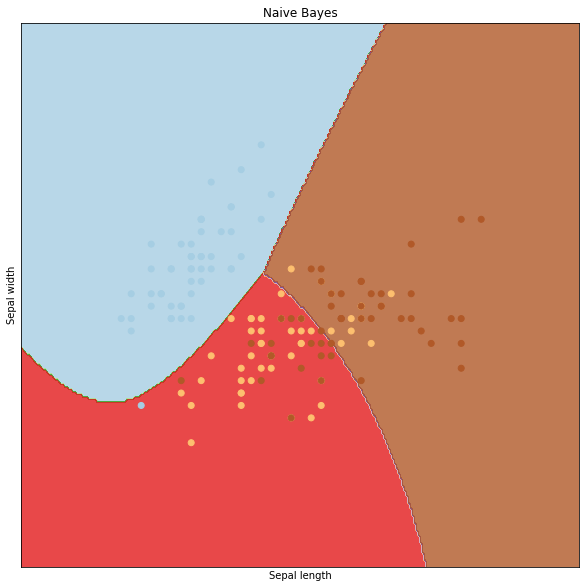

In [20]:


# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig = plt.figure(figsize=(10,10))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].

Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Naive Bayes')

plt.show()